<a href="https://colab.research.google.com/github/ShaimaaAhmedM01/Energy-Consumption-Demand-Analysis/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

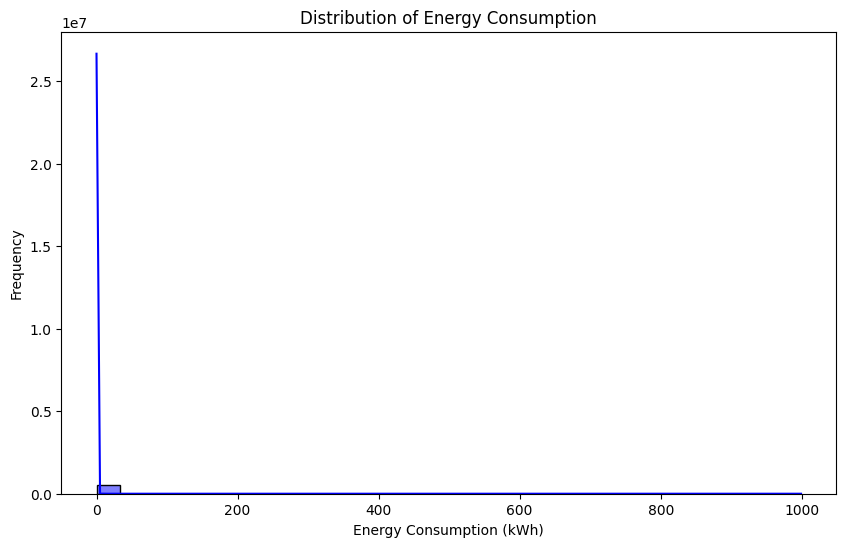

<ipython-input-2-6514feaeb917>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='region', y='KWH/hh (per half hour)', palette='Set2')


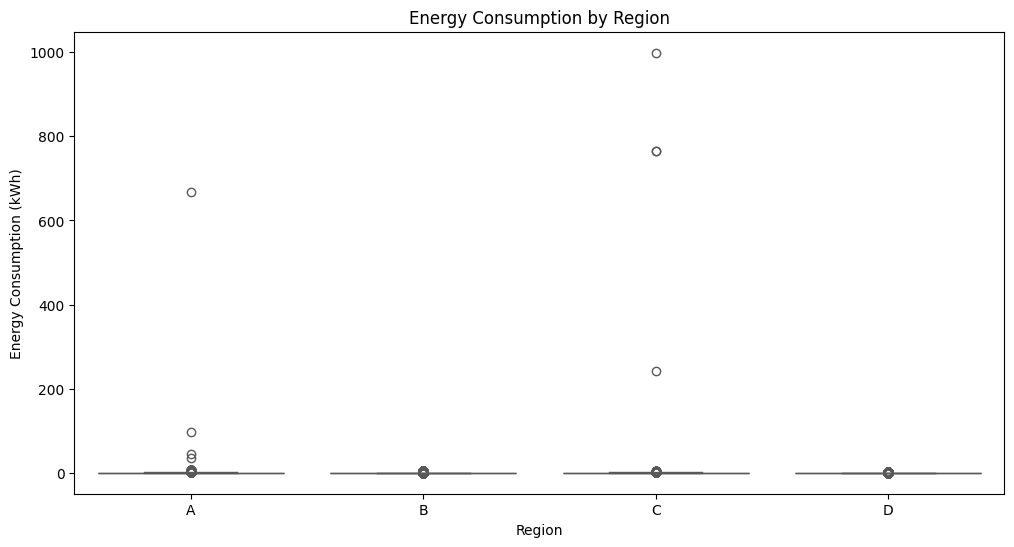

<ipython-input-2-6514feaeb917>:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=merged_data, x='Hour', y='KWH/hh (per half hour)', ci=None, hue='region', marker='o')


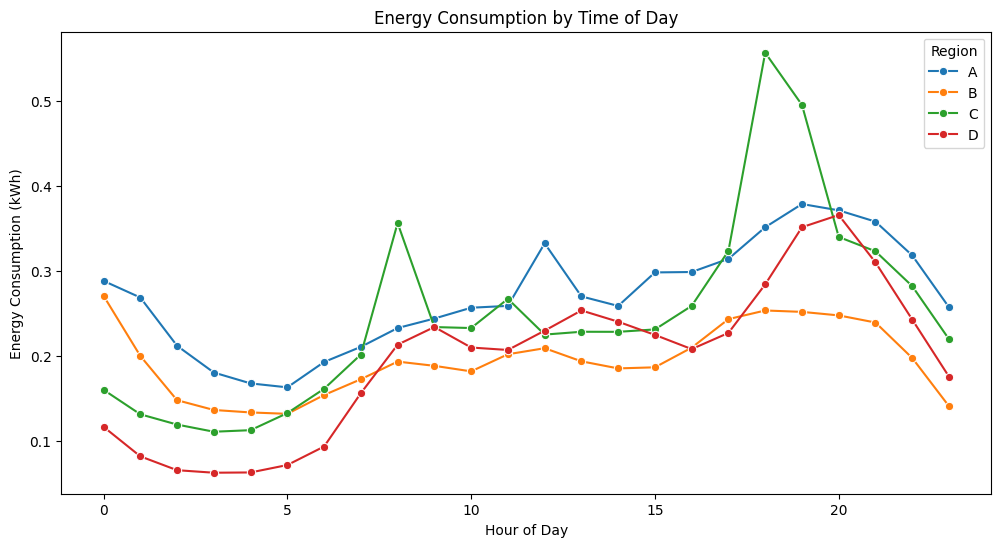

ANOVA Result for Region Effect on Energy Consumption: F_onewayResult(statistic=38.83430935535937, pvalue=4.396990942096681e-25)

Post-hoc Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  -0.0755    0.0 -0.0941 -0.0569   True
     A      C   -0.023 0.0141 -0.0426 -0.0033   True
     A      D  -0.0748 0.0008 -0.1253 -0.0243   True
     B      C   0.0526    0.0   0.032  0.0731   True
     B      D   0.0007    1.0 -0.0502  0.0516  False
     C      D  -0.0519 0.0461 -0.1031 -0.0006   True
----------------------------------------------------

Correlation Between Hour of Day and Energy Consumption:
Correlation: 0.01964860583877453, P-value: 1.0056448042483249e-47


<ipython-input-2-6514feaeb917>:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_consumption_cells['Savings_EGP'] = low_consumption_cells.apply(calculate_savings, axis=1)



Threshold for Low Consumption: 0.065
Total Energy Saved (kWh): 4737.483
Total Cost Savings (EGP): 326.4125786999999


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine the three parts of the energy consumption dataset
part1 = pd.read_csv('/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_001.csv')
part2 = pd.read_csv('/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_002.csv')
part3 = pd.read_csv('/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_003.csv')

# Combine the datasets
energy_data_combined = pd.concat([part1, part2, part3], ignore_index=True)

# Save the combined dataset as a single file for use in the analysis
energy_data_combined.to_csv('Sites_Energy_Consumption.csv', index=False)

# Load datasets
energy_file_path = 'Sites_Energy_Consumption.csv'
demand_file_path = '/content/drive/MyDrive/Data/Final Project/Demand.xlsx'

# Read the data
energy_data = pd.read_csv(energy_file_path)
demand_data = pd.read_excel(demand_file_path)

# Data Cleaning and Preprocessing
# Fix the DateTime column
energy_data['DateTime'] = pd.to_datetime(energy_data['DateTime'], errors='coerce', format='%H:%M:%S %d,%m,%y')
demand_data['DemandDateTime'] = pd.to_datetime(demand_data['DemandDateTime'], errors='coerce')

# Check for missing values and handle them
energy_data.dropna(inplace=True)
demand_data.dropna(inplace=True)

# Merge datasets on datetime (align half-hour intervals)
merged_data = pd.merge_asof(
    energy_data.sort_values('DateTime'),
    demand_data.sort_values('DemandDateTime'),
    left_on='DateTime',
    right_on='DemandDateTime',
    direction='backward'
)

# Column cleanup
merged_data.columns = merged_data.columns.str.strip()

# Exploratory Data Analysis
# Distribution of energy consumption
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['KWH/hh (per half hour)'], kde=True, bins=30, color='blue')
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

# Energy consumption by region
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='region', y='KWH/hh (per half hour)', palette='Set2')
plt.title('Energy Consumption by Region')
plt.xlabel('Region')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Energy consumption over time of day
merged_data['Hour'] = merged_data['DateTime'].dt.hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_data, x='Hour', y='KWH/hh (per half hour)', ci=None, hue='region', marker='o')
plt.title('Energy Consumption by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(title='Region')
plt.show()

# Hypothesis Testing
# 1. Does the region significantly affect energy consumption?
region_groups = [group['KWH/hh (per half hour)'].values for _, group in merged_data.groupby('region')]
anova_result = f_oneway(*region_groups)
print("ANOVA Result for Region Effect on Energy Consumption:", anova_result)

# If significant, perform post-hoc test
tukey_result = pairwise_tukeyhsd(merged_data['KWH/hh (per half hour)'], merged_data['region'])
print("\nPost-hoc Test Results:")
print(tukey_result)

# 2. Is there a relationship between time of day and energy consumption?
correlation, p_value = pearsonr(merged_data['Hour'], merged_data['KWH/hh (per half hour)'])
print("\nCorrelation Between Hour of Day and Energy Consumption:")
print(f"Correlation: {correlation}, P-value: {p_value}")

# Threshold Recommendation
# Define a threshold for low consumption
threshold = merged_data['KWH/hh (per half hour)'].quantile(0.25)
low_consumption_cells = merged_data[merged_data['KWH/hh (per half hour)'] <= threshold]
savings_kwh = low_consumption_cells['KWH/hh (per half hour)'].sum()

# Calculate cost savings based on demand prices
def calculate_savings(row):
    if row['Demand'] == 'High':
        return row['KWH/hh (per half hour)'] * 0.7721
    elif row['Demand'] == 'Normal':
        return row['KWH/hh (per half hour)'] * 0.1946
    else:  # Low
        return row['KWH/hh (per half hour)'] * 0.0689

low_consumption_cells['Savings_EGP'] = low_consumption_cells.apply(calculate_savings, axis=1)
total_savings_egp = low_consumption_cells['Savings_EGP'].sum()

print("\nThreshold for Low Consumption:", threshold)
print("Total Energy Saved (kWh):", savings_kwh)
print("Total Cost Savings (EGP):", total_savings_egp)

# Save processed data for future use
merged_data.to_csv('Processed_Energy_Data.csv', index=False)
